In [1]:
%pylab inline
import pandas as pd

Populating the interactive namespace from numpy and matplotlib


In [2]:
import gc
import cPickle as pickle
import fastparquet

weather data from https://www1.ncdc.noaa.gov/pub/data/ghcn/daily

# keep what is needed 

In [3]:
def reverse_map(d):
    return {v:k for k,v in d.items()}
def encoding_dict(names):
    names=sorted(names)
    a=dict(enumerate(names))
    b=reverse_map(a)
    return b,a

In [4]:
visits=pd.read_csv("../input/air_visit_data.csv",parse_dates=['visit_date'])
print visits.shape

(252108, 3)


In [5]:
dates=pd.read_csv("../input/date_info.csv",parse_dates=['calendar_date'])
print dates.shape

(517, 3)


In [6]:
stores=sorted(set(visits['air_store_id']))
len(stores)

829

In [7]:
date_list=pd.date_range(pd.to_datetime("2016-01-01"),pd.to_datetime("2017-05-31"))
len(date_list)

517

In [8]:
reserves=pd.read_csv("../input/new_reserves.csv",parse_dates=['visit_datetime','reserve_datetime'])
reserves.shape,reserves['reserve_datetime'].max()

((120561, 6), Timestamp('2017-04-22 00:00:00'))

In [9]:
storeinfo=pd.read_csv("../input/newstoreinfo.csv")
storeinfo.shape

(892, 10)

# put train test together

In [10]:
sample=pd.read_csv("../input/sample_submission.csv")
sample['air_store_id']=sample['id'].map(lambda u: "_".join(u.split("_")[:2]))
sample['visit_date']=sample['id'].map(lambda u: pd.to_datetime(u.split("_")[2],format="%Y-%m-%d"))

In [11]:
sample=sample[visits.columns]
sample['visitors']=np.nan

In [12]:
sample['visit_date'].min()

Timestamp('2017-04-23 00:00:00')

In [13]:
train_test=pd.concat([visits,sample])

In [14]:
train_test['visitors']=np.log1p(train_test['visitors'])

In [15]:
train_test.head()

air_store_id visit_date  visitors
0  air_ba937bf13d40fb24 2016-01-13  3.258097
1  air_ba937bf13d40fb24 2016-01-14  3.496508
2  air_ba937bf13d40fb24 2016-01-15  3.401197
3  air_ba937bf13d40fb24 2016-01-16  3.135494
4  air_ba937bf13d40fb24 2016-01-18  1.945910

In [16]:
newidx=[[u,v] for u in stores for v in date_list]
len(newidx)

428593

In [17]:
tmpdf=pd.DataFrame(newidx,columns=[u'air_store_id', u'visit_date'])

In [18]:
train_test=pd.merge(tmpdf,train_test, on = [u'air_store_id', u'visit_date'],how='left')

In [19]:
train_test.head()

air_store_id visit_date  visitors
0  air_00a91d42b08b08d9 2016-01-01       NaN
1  air_00a91d42b08b08d9 2016-01-02       NaN
2  air_00a91d42b08b08d9 2016-01-03       NaN
3  air_00a91d42b08b08d9 2016-01-04       NaN
4  air_00a91d42b08b08d9 2016-01-05       NaN

In [20]:
len(stores),len(date_list)

(829, 517)

In [21]:
store_map,_=encoding_dict(stores)
train_test['air_store_id']=train_test['air_store_id'].map(lambda u: store_map[u])

In [22]:
date_map,_=encoding_dict(date_list)
train_test['visit_date']=train_test['visit_date'].map(lambda u: date_map[u])

In [23]:
train_test.head()

air_store_id  visit_date  visitors
0             0           0       NaN
1             0           1       NaN
2             0           2       NaN
3             0           3       NaN
4             0           4       NaN

In [24]:
train_test.shape,829* 517

((428593, 3), 428593)

# make reservers

In [12]:
np.sum([u<pd.to_datetime('2017-04-23') for u in date_list]), \
np.sum([u>=pd.to_datetime('2017-04-23') for u in date_list])

(478, 39)

In [34]:
reserves.max()

store_id            air_fee8dcf4d619598e
visit_datetime       2017-05-31 00:00:00
reserve_datetime     2017-04-22 00:00:00
reserve_visitors                     100
flag                                   1
gap                                  393
dtype: object

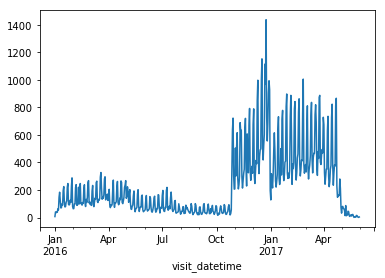

In [29]:
reserves.groupby('visit_datetime').count().iloc[:,0].plot()

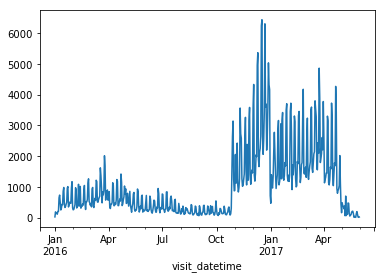

In [30]:
reserves.groupby('visit_datetime').sum().iloc[:,0].plot()

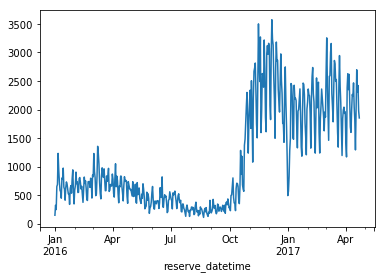

In [31]:
reserves.groupby('reserve_datetime').sum().iloc[:,0].plot()

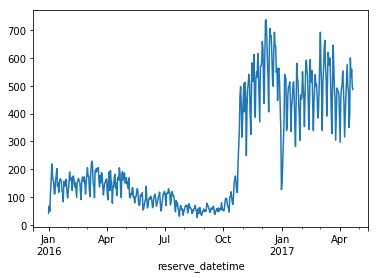

In [32]:
reserves.groupby('reserve_datetime').count().iloc[:,0].plot()

In [ ]:
reserves.groupby('visit_datetime').sum().iloc[:,0].plot()

In [23]:
for i in range(39):
    ind=reserves['gap']==i
    ind &= reserves['visit_datetime']<pd.to_datetime('2017-04-23')
    a=reserves[ind][['visit_datetime','reserve_visitors']].groupby(['visit_datetime']).count()
    #display(a)
    print "gap={}, rv_sum={}, rv_cnt={}, store_has_rv_per_day={}".format(i, a.sum()[0],a.count()[0],a.sum()[0]/478.)


gap=0, rv_sum=29712, rv_cnt=478, store_has_rv_per_day=62.1589958159
gap=1, rv_sum=17985, rv_cnt=478, store_has_rv_per_day=37.6255230126
gap=2, rv_sum=11608, rv_cnt=471, store_has_rv_per_day=24.2845188285
gap=3, rv_sum=8490, rv_cnt=469, store_has_rv_per_day=17.7615062762
gap=4, rv_sum=6582, rv_cnt=467, store_has_rv_per_day=13.769874477
gap=5, rv_sum=5137, rv_cnt=455, store_has_rv_per_day=10.7468619247
gap=6, rv_sum=4353, rv_cnt=453, store_has_rv_per_day=9.10669456067
gap=7, rv_sum=4052, rv_cnt=444, store_has_rv_per_day=8.4769874477
gap=8, rv_sum=3330, rv_cnt=426, store_has_rv_per_day=6.96652719665
gap=9, rv_sum=2790, rv_cnt=395, store_has_rv_per_day=5.83682008368
gap=10, rv_sum=2406, rv_cnt=391, store_has_rv_per_day=5.03347280335
gap=11, rv_sum=2032, rv_cnt=380, store_has_rv_per_day=4.2510460251
gap=12, rv_sum=1743, rv_cnt=364, store_has_rv_per_day=3.64644351464
gap=13, rv_sum=1596, rv_cnt=365, store_has_rv_per_day=3.33891213389
gap=14, rv_sum=1515, rv_cnt=346, store_has_rv_per_day=3.16

In [24]:
for i in range(39):
    ind=reserves['gap']==i
    ind &= reserves['visit_datetime']>=pd.to_datetime('2017-04-23')
    a=reserves[ind][['visit_datetime','reserve_visitors']].groupby(['visit_datetime']).count()
    #display(a)
    print "gap={}, rv_sum={}, rv_cnt={}, store_has_rv_per_day={}".format(i, a.sum()[0],a.count()[0],a.sum()[0]/39.)


gap=0, rv_sum=1, rv_cnt=1, store_has_rv_per_day=0.025641025641
gap=1, rv_sum=56, rv_cnt=1, store_has_rv_per_day=1.4358974359
gap=2, rv_sum=49, rv_cnt=2, store_has_rv_per_day=1.25641025641
gap=3, rv_sum=57, rv_cnt=3, store_has_rv_per_day=1.46153846154
gap=4, rv_sum=82, rv_cnt=4, store_has_rv_per_day=2.10256410256
gap=5, rv_sum=77, rv_cnt=5, store_has_rv_per_day=1.97435897436
gap=6, rv_sum=110, rv_cnt=6, store_has_rv_per_day=2.82051282051
gap=7, rv_sum=133, rv_cnt=7, store_has_rv_per_day=3.41025641026
gap=8, rv_sum=102, rv_cnt=8, store_has_rv_per_day=2.61538461538
gap=9, rv_sum=81, rv_cnt=9, store_has_rv_per_day=2.07692307692
gap=10, rv_sum=96, rv_cnt=10, store_has_rv_per_day=2.46153846154
gap=11, rv_sum=89, rv_cnt=11, store_has_rv_per_day=2.28205128205
gap=12, rv_sum=73, rv_cnt=12, store_has_rv_per_day=1.87179487179
gap=13, rv_sum=91, rv_cnt=12, store_has_rv_per_day=2.33333333333
gap=14, rv_sum=85, rv_cnt=14, store_has_rv_per_day=2.17948717949
gap=15, rv_sum=53, rv_cnt=14, store_has_rv_

to few records for test set reservation, seems useless 

# store info

In [28]:
store_map,_=encoding_dict(stores)
storeinfo['store_id']=storeinfo['store_id'].map(lambda u: store_map[u])

In [29]:
storeinfo.head()

store_id      genre_name                     area_name   latitude  \
0        42  Italian/French  Hyōgo-ken Kōbe-shi Kumoidōri  34.695124   
1       390  Italian/French  Hyōgo-ken Kōbe-shi Kumoidōri  34.695124   
2       825  Italian/French  Hyōgo-ken Kōbe-shi Kumoidōri  34.695124   
3       527  Italian/French  Hyōgo-ken Kōbe-shi Kumoidōri  34.695124   
4       412  Italian/French  Tōkyō-to Minato-ku Shibakōen  35.658068   

    longitude  flag   geo1    geo2      station  station_distance  
0  135.197852     0  Hyōgo    Kōbe  JA000047770              1.83  
1  135.197852     0  Hyōgo    Kōbe  JA000047770              1.83  
2  135.197852     0  Hyōgo    Kōbe  JA000047770              1.83  
3  135.197852     0  Hyōgo    Kōbe  JA000047770              1.83  
4  139.751599     0  Tōkyō  Minato  JA000047662              3.10

## geo1

In [30]:
def f(name,info,train_test):
    unique_names=set(info[name])
    print "unique names", len(unique_names)

    mapdict=info[name].to_dict()
    train_test[name]=train_test['air_store_id'].map(lambda u:  mapdict[u])

    #for count 1
    lst=[]
    for geo1 in unique_names:
        tmpdict=train_test[train_test[name]==geo1][['air_store_id','visit_date']].groupby('air_store_id').min().iloc[:,0]
        for d in set(train_test['visit_date']):
            c=np.sum(tmpdict<=d)
            lst.append([d,geo1,c])
    df=pd.DataFrame(lst,columns=['visit_date',name,'{}_store_count'.format(name)])
    train_test=pd.merge(train_test,df,on=['visit_date',name],how='left')
    
    df=train_test[['visit_date',name,'visitors']].groupby([ 'visit_date',name]).count().reset_index()
    df=df.rename(columns={"visitors":"{}_visitors_count".format(name)})
    train_test=pd.merge(train_test,df,on=['visit_date',name],how='left')
    
    df=train_test[['visit_date',name,'visitors']].groupby([ 'visit_date',name]).mean().reset_index()
    df=df.rename(columns={"visitors":"{}_visitors_mean".format(name)})    
    train_test=pd.merge(train_test,df,on=['visit_date',name],how='left')

    return train_test

In [31]:
info=storeinfo.groupby(['store_id']).first()
info.shape,storeinfo.shape 

((829, 9), (892, 10))

In [32]:
train_test=f('geo1',info,train_test)

unique names 9


In [33]:
train_test=f('geo2',info,train_test)

unique names 55


In [34]:
train_test=f('station',info,train_test)

unique names 20


In [35]:
info=storeinfo[storeinfo['flag']==0]

In [36]:
train_test=f('genre_name',info,train_test)

unique names 14


# weather

In [37]:
date_map,_=encoding_dict(date_list)

In [38]:
TMAX=pd.read_csv("../input/weather_tmax.csv",index_col=0)
TMAX.index.name='visit_date'
TMAX.index=TMAX.index.map(lambda u: date_map[pd.to_datetime(u)])
TMAX=TMAX.to_dict()
train_test['TMAX']=train_test.apply(lambda u: TMAX[u['station']][u['visit_date']],axis=1)

In [39]:
TMAX=pd.read_csv("../input/weather_tmin.csv",index_col=0)
TMAX.index.name='visit_date'
TMAX.index=TMAX.index.map(lambda u: date_map[pd.to_datetime(u)])
TMAX=TMAX.to_dict()
train_test['TMIN']=train_test.apply(lambda u: TMAX[u['station']][u['visit_date']],axis=1)

In [40]:
TMAX=pd.read_csv("../input/weather_tavg.csv",index_col=0)
TMAX.index.name='visit_date'
TMAX.index=TMAX.index.map(lambda u: date_map[pd.to_datetime(u)])
TMAX=TMAX.to_dict()
train_test['TAVG']=train_test.apply(lambda u: TMAX[u['station']][u['visit_date']],axis=1)

In [41]:
TMAX=pd.read_csv("../input/weather_prcp.csv",index_col=0)
TMAX.index.name='visit_date'
TMAX.index=TMAX.index.map(lambda u: date_map[pd.to_datetime(u)])
TMAX=TMAX.to_dict()
train_test['PRCP']=train_test.apply(lambda u: TMAX[u['station']][u['visit_date']],axis=1)

# dates

In [42]:
dates['calendar_date']=dates['calendar_date'].map(lambda u: date_map[u])

In [43]:
dates=dates.set_index('calendar_date')

In [44]:
def f(train_test):
    unique_names=set(dates['day_of_week'])
    print "unique names", len(unique_names)

    name='day_of_week'
    mapdict=dates['day_of_week'].to_dict()
    train_test[name]=train_test['visit_date'].map(lambda u:  mapdict[u])

    #for count 1
    lst=[]
    for geo1 in unique_names:
        tmpdict=train_test[train_test[name]==geo1][['air_store_id','visit_date']].groupby('air_store_id').min().iloc[:,0]
        for d in set(train_test['visit_date']):
            c=np.sum(tmpdict<=d)
            lst.append([d,geo1,c])
    df=pd.DataFrame(lst,columns=['visit_date',name,'{}_store_count'.format(name)])
    train_test=pd.merge(train_test,df,on=['visit_date',name],how='left')
    
    df=train_test[['visit_date',name,'visitors']].groupby([ 'visit_date',name]).count().reset_index()
    df=df.rename(columns={"visitors":"{}_visitors_count".format(name)})
    train_test=pd.merge(train_test,df,on=['visit_date',name],how='left')
    
    df=train_test[['visit_date',name,'visitors']].groupby([ 'visit_date',name]).mean().reset_index()
    df=df.rename(columns={"visitors":"{}_visitors_mean".format(name)})    
    train_test=pd.merge(train_test,df,on=['visit_date',name],how='left')

    return train_test

In [45]:
train_test=f(train_test)

unique names 7


In [46]:
tmpdict=dates['holiday_flg'].to_dict()

In [47]:
train_test['holiday']=train_test['visit_date'].map(lambda u: tmpdict[u])

In [48]:
train_test.head()

air_store_id  visit_date  visitors   geo1  geo1_store_count  \
0             0           0       NaN  Tōkyō               444   
1             0           1       NaN  Tōkyō               444   
2             0           2       NaN  Tōkyō               444   
3             0           3       NaN  Tōkyō               444   
4             0           4       NaN  Tōkyō               444   

   geo1_visitors_count  geo1_visitors_mean     geo2  geo2_store_count  \
0                   20            2.620946  Chiyoda                22   
1                   18            2.811538  Chiyoda                22   
2                   27            3.030371  Chiyoda                22   
3                   68            2.735346  Chiyoda                22   
4                  114            2.639541  Chiyoda                22   

   geo2_visitors_count   ...     genre_name_visitors_mean  TMAX  TMIN  TAVG  \
0                    1   ...                     3.009525  12.1   2.6   7.3   
1                    1   ...                     2.615095  13.4   2.6   7.4   
2                    1   ...                     2.684705  16.2   3.0   9.8   
3                    3   ...                     2.599179  15.2   4.4   9.9   
4                    6   ...                     2.614342  15.4   5.1  10.8   

   PRCP day_of_week  day_of_week_store_count  day_of_week_visitors_count  \
0   0.0      Friday                      829                          48   
1   0.0    Saturday                      829                          63   
2   0.0      Sunday                      829                          81   
3   0.0      Monday                      829                         157   
4   0.0     Tuesday                      829                         231   

   day_of_week_visitors_mean  holiday  
0                   2.632437        1  
1                   3.077320        1  
2                   3.091436        1  
3                   2.829584        0  
4                   2.639654        0  

[5 rows x 28 columns]

In [49]:
for col in train_test.columns:
    if train_test[col].dtype==np.float64:
        train_test[col]=train_test[col].astype(np.float32)
    if train_test[col].dtype==np.int64:
        train_test[col]=train_test[col].astype(np.int32)        

In [50]:
train_test['is_rain']=(train_test['PRCP']>0).astype(np.float32)
train_test['PRCP'][train_test['PRCP']==0]=np.nan
train_test['holiday']=train_test['holiday'].astype(np.float32)

/home/bo/anaconda2/envs/tensorflow14/lib/python2.7/site-packages/ipykernel/__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app


In [51]:
train_test.info(verbose=False)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 428593 entries, 0 to 428592
Columns: 29 entries, air_store_id to is_rain
dtypes: float32(12), int32(12), object(5)
memory usage: 58.9+ MB


In [52]:
fastparquet.write("../input/train_test.parq",train_test,compression='SNAPPY')